In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models'])
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_kd_targets, get_weight_penalty
import copy
from tensorboardX import SummaryWriter
writer = SummaryWriter('tensorboard/runs/')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [2]:
model = models.LeNet_300_100()
#print_dims(model)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='original_model/'

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_loader, model, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model, get_loss=True)
    weight_penalty = get_weight_penalty(model)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        
    #print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
    
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

In [64]:
#Get KD Targets   
model_name = 'LeNet_300_100'
retraining_epochs=100
for temp in range (1,2):
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()
    train_kd_dataset = get_kd_targets(train_dataset, model, temp)
    train_kd_loader = torch.utils.data.DataLoader(dataset=train_kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_loader, model_kd, get_loss=True)
        train_acc = test_accuracy(train_loader_full, model_kd, get_loss=True)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%10==9):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

Epoch: 10. Train CE Loss: 1.519, Train Accuracy: 98.198, Test CE Loss: 1.523, Test Accuracy: 97.230, Model L2: 18.349


KeyboardInterrupt: 

### 3. Prune Model

In [9]:
temp = 1
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e100.m'.format(temp)).cuda()
model_c = models.LeNet_300_100().cuda()
pruner = model_prune(model_kd.state_dict())
deviation_list = [x/10.0 for x in range(0,21)]
percentile_list = range(0,101,5)
graph_title = "compressed_model_T{}/".format(temp)

In [10]:
test_acc_kd = test_accuracy(test_loader, model_kd, get_loss=True)
train_acc_kd = test_accuracy(train_loader_full, model_kd, get_loss=True)
weight_penalty_kd = get_weight_penalty(model_kd)

test_acc_o = test_accuracy(test_loader, model, get_loss=True)
train_acc_o = test_accuracy(train_loader_full, model, get_loss=True)
weight_penalty_o = get_weight_penalty(model)

writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)


In [11]:
dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
for lim in deviation_list:
    model_c.load_state_dict(pruner.deviation_prune(lim))
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    
    dev_res['train ce'].append(train_acc[1])
    dev_res['test ce'].append(test_acc[1])
    dev_res['train acc'].append(train_acc[0])
    dev_res['test acc'].append(test_acc[0])
    dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    dev_res['L2'].append(weight_penalty)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
    writer.add_scalars(graph_title + 'Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
    writer.add_scalars(graph_title + 'L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.514, Train Accuracy: 98.490, Test CE Loss: 1.518, Test Accuracy: 97.610, Model L2: 18.073, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.514, Train Accuracy: 98.475, Test CE Loss: 1.519, Test Accuracy: 97.600, Model L2: 18.073, Parameters Pruned: 150471/266610 - 56.439%
Train CE Loss: 1.515, Train Accuracy: 98.393, Test CE Loss: 1.520, Test Accuracy: 97.510, Model L2: 18.075, Parameters Pruned: 177037/266610 - 66.403%
Train CE Loss: 1.516, Train Accuracy: 98.365, Test CE Loss: 1.521, Test Accuracy: 97.450, Model L2: 18.051, Parameters Pruned: 187216/266610 - 70.221%
Train CE Loss: 1.520, Train Accuracy: 98.225, Test CE Loss: 1.524, Test Accuracy: 97.370, Model L2: 18.005, Parameters Pruned: 195617/266610 - 73.372%
Train CE Loss: 1.531, Train Accuracy: 97.748, Test CE Loss: 1.534, Test Accuracy: 96.890, Model L2: 17.931, Parameters Pruned: 202706/266610 - 76.031%
Train CE Loss: 1.547, Train Accuracy: 97.098, Test CE Loss: 1.548, Test Accuracy: 96.210, Model L2: 

In [12]:
perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []} 

for lim in percentile_list:
    model_c.load_state_dict(pruner.percentile_prune(lim))
    
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    perc_res['train ce'].append(train_acc[1])
    perc_res['test ce'].append(test_acc[1])
    perc_res['train acc'].append(train_acc[0])
    perc_res['test acc'].append(test_acc[0])
    perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    perc_res['L2'].append(weight_penalty)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
    writer.add_scalars(graph_title + 'Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
    writer.add_scalars(graph_title + 'L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.514, Train Accuracy: 98.490, Test CE Loss: 1.518, Test Accuracy: 97.610, Model L2: 18.073, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.514, Train Accuracy: 98.490, Test CE Loss: 1.518, Test Accuracy: 97.610, Model L2: 18.073, Parameters Pruned: 13310/266610 - 4.992%
Train CE Loss: 1.514, Train Accuracy: 98.488, Test CE Loss: 1.518, Test Accuracy: 97.620, Model L2: 18.072, Parameters Pruned: 26620/266610 - 9.985%
Train CE Loss: 1.514, Train Accuracy: 98.462, Test CE Loss: 1.519, Test Accuracy: 97.590, Model L2: 18.070, Parameters Pruned: 39930/266610 - 14.977%
Train CE Loss: 1.515, Train Accuracy: 98.440, Test CE Loss: 1.520, Test Accuracy: 97.530, Model L2: 18.065, Parameters Pruned: 53240/266610 - 19.969%
Train CE Loss: 1.515, Train Accuracy: 98.447, Test CE Loss: 1.520, Test Accuracy: 97.530, Model L2: 18.052, Parameters Pruned: 66550/266610 - 24.962%
Train CE Loss: 1.518, Train Accuracy: 98.355, Test CE Loss: 1.522, Test Accuracy: 97.440, Model L2: 18.032,

AttributeError: 'module' object has no attribute 'canvas'

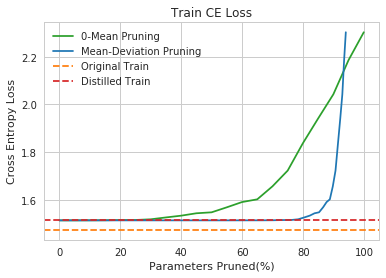

In [46]:
plt.clf()
plt.plot(perc_res['pruned'], perc_res['train ce'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['train ce'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=train_acc_o[1], label="Original Train", color = c3, linestyle='--')
plt.axhline(y=train_acc_kd[1], label="Distilled Train", color = c4, linestyle='--')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=2)
plt.title("Train CE Loss")

plt.canvas.draw()

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

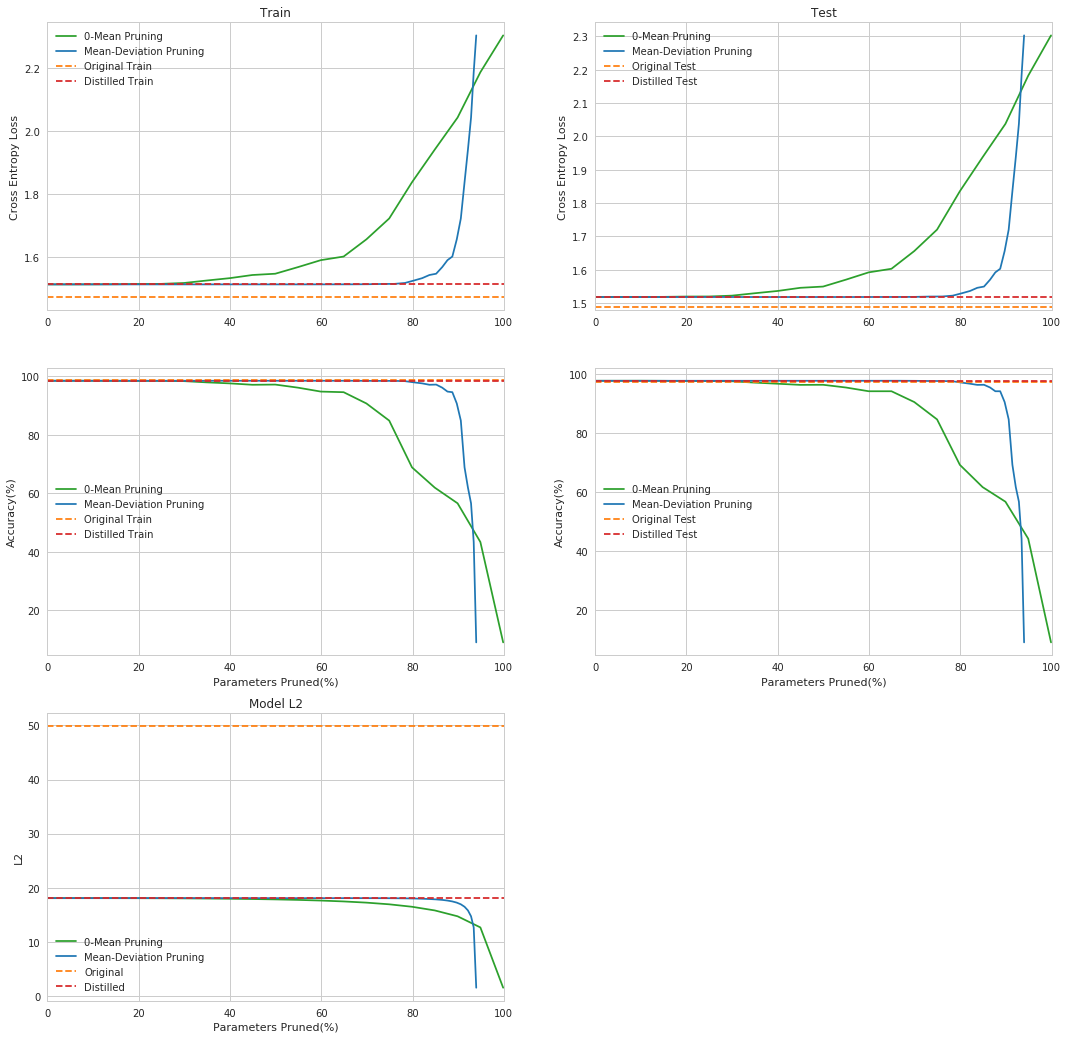

In [59]:
c1 = '#2ca02c'
c2 = '#1f77b4'
c3 = '#ff7f0e'
c4 = '#d62728'

ncols = 2
nrows = 3

plt.clf()
plt.figure(figsize=(18,18))
plt.subplot(nrows, ncols, 1)
plt.plot(perc_res['pruned'], perc_res['train ce'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['train ce'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=train_acc_o[1], label="Original Train", color = c3, linestyle='--')
plt.axhline(y=train_acc_kd[1], label="Distilled Train", color = c4, linestyle='--')
plt.xlim([0, 100])
plt.ylabel("Cross Entropy Loss")
#plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=2)
plt.title("Train")

plt.subplot(nrows, ncols, 2)
plt.plot(perc_res['pruned'], perc_res['test ce'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['test ce'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=test_acc_o[1], label="Original Test", color = c3, linestyle='--')
plt.axhline(y=test_acc_kd[1], label="Distilled Test", color = c4, linestyle='--')
plt.xlim([0, 100])
plt.ylabel("Cross Entropy Loss")
#plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=2)
plt.title("Test")

plt.subplot(nrows, ncols, 3)
plt.plot(perc_res['pruned'], perc_res['train acc'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['train acc'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=train_acc_o[0], label="Original Train", color = c3, linestyle='--')
plt.axhline(y=train_acc_kd[0], label="Distilled Train", color = c4, linestyle='--')
plt.xlim([0, 100])
plt.ylabel("Accuracy(%)")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=6)
#plt.title("Train Accuracy")

plt.subplot(nrows, ncols, 4)
plt.plot(perc_res['pruned'], perc_res['test acc'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['test acc'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=test_acc_o[0], label="Original Test", color = c3, linestyle='--')
plt.axhline(y=test_acc_kd[0], label="Distilled Test", color = c4, linestyle='--')
plt.xlim([0, 100])
plt.ylabel("Accuracy(%)")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=6)
#plt.title("Test Accuracy")

plt.subplot(nrows, ncols, 5)
plt.plot(perc_res['pruned'], perc_res['L2'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['L2'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=weight_penalty_o, label="Original", color = c3, linestyle='--')
plt.axhline(y=weight_penalty_kd, label="Distilled", color = c4, linestyle='--')
plt.xlim([0, 100])
plt.ylabel("L2")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=3)
plt.title("Model L2")

plt.show()